In [1]:
import numpy as np
import extq
import ivac
import pyemma
import glob
import sys
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
sys.path.insert(1, "../python")
sys.path.insert(1, "../..")
import util
import kde

In [3]:
import seaborn as sns

plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


## load CVs 

In [7]:
with np.load("../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [8]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
cv_trajs = np.split(cv_arr, traj_inds)

In [9]:
cv_arr.shape

(6580000, 2)

In [10]:
# take only last 30 features (Cz - Cd distances)
data_cz = [traj[:, 30:] for traj in data]

## Models 

In [11]:
feat2_models = np.load("../data/models_feat2.npy")

In [12]:
models_cz = feat2_models[:, 30:]

# two-radial basis 

In [13]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "D186", "E183"):
        sb_labels.append(f"{r} - {n}")

In [14]:
sb_labels

['R217 - D129',
 'R217 - D136',
 'R217 - D151',
 'R217 - D164',
 'R217 - D186',
 'R217 - E183',
 'R223 - D129',
 'R223 - D136',
 'R223 - D151',
 'R223 - D164',
 'R223 - D186',
 'R223 - E183',
 'R226 - D129',
 'R226 - D136',
 'R226 - D151',
 'R226 - D164',
 'R226 - D186',
 'R226 - E183',
 'R229 - D129',
 'R229 - D136',
 'R229 - D151',
 'R229 - D164',
 'R229 - D186',
 'R229 - E183',
 'R232 - D129',
 'R232 - D136',
 'R232 - D151',
 'R232 - D164',
 'R232 - D186',
 'R232 - E183']

In [14]:
# useful salt bridges
# R223-D129, R226-D129, R229-D129, R226-D186, R229-D186, R232-D186
sb_ids = [36, 42, 48, 46, 52, 58]

In [73]:
for idx in sb_ids:
    print(sb_labels[idx - 30])

R223 - D129
R226 - D129
R229 - D129
R226 - D186
R229 - D186
R232 - D186


In [15]:
data_sb = [traj[:, sb_ids] for traj in data]

In [16]:
data_sb_arr = np.concatenate(data_sb)
data_sb_arr.shape

(6580000, 6)

In [32]:
# define radial basis functions
def gauss_short(r, r0, d0):
    return np.where(r < d0, 1, np.exp(-((r - d0) ** 2) / (2 * r0 ** 2)))


def gauss_long(r, r0, d0):
    return 1 - gauss_short(r, r0, d0)

Text(0.5, 1.0, 'Short and long distance Gaussian basis')

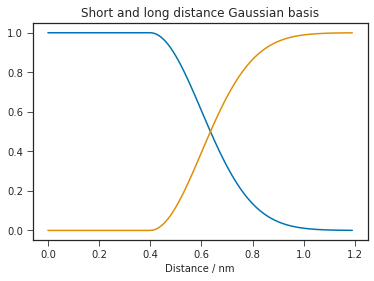

In [38]:
x = np.arange(0, 1.2, 0.01)
plt.plot(x, gauss_short(x, 0.2, 0.4))
plt.plot(x, gauss_long(x, 0.2, 0.4))
plt.xlabel("Distance / nm")
plt.title("Short and long distance Gaussian basis")

## transform data 

In [40]:
data_short = gauss_short(data_sb_arr, 0.2, 0.4)
data_long = gauss_long(data_sb_arr, 0.2, 0.4)
print(data_short.shape)

(6580000, 6)


In [46]:
# first basis would be data_short[:, 0] * data_short[:, 1] ... * data_short[:, 5]
data_basis = [np.ones(data_arr.shape[0])]
for i in range(len(sb_ids)):
    new_basis = []
    for temp in data_basis:
        new_basis.append(np.multiply(temp, data_short[:, i]))
        new_basis.append(np.multiply(temp, data_long[:, i]))
    data_basis = new_basis
    print(len(data_basis))

2
4
8
16
32
64


In [47]:
data_basis = np.array(data_basis)

In [48]:
data_basis.shape

(64, 6580000)

In [49]:
data_basis = data_basis.T

In [51]:
data_basis_trajs = np.split(data_basis, traj_inds)

## IVAC

In [55]:
livac = ivac.LinearIVAC(
    minlag=1, maxlag=3000, nevecs=5, reweight=False, adjust=True, method="fft"
)
livac.fit(data_basis_trajs)

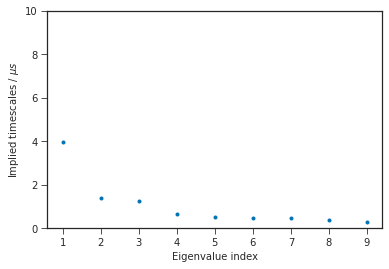

In [214]:
# f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 10])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/ivac-radial-its.png", dpi=300)

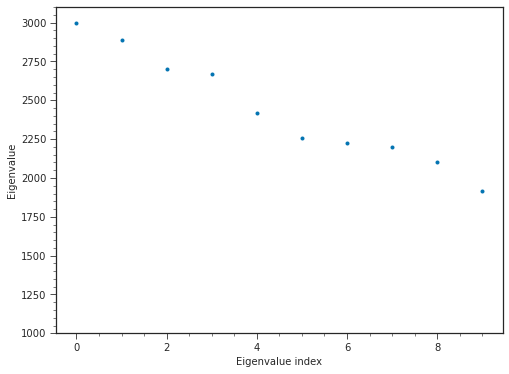

In [215]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/ivac-radial-evals.png", dpi=300)

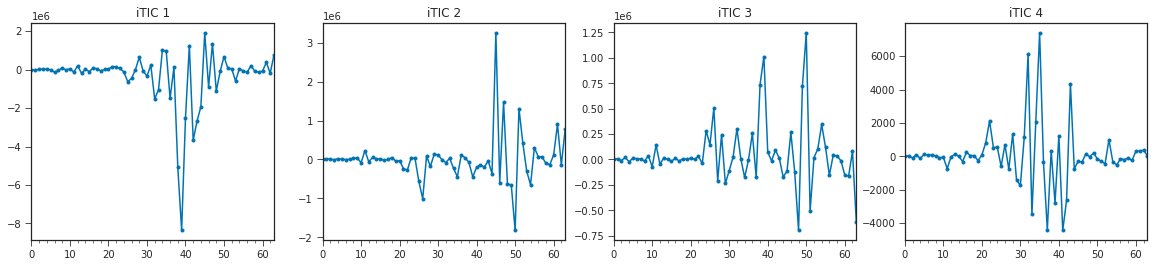

In [216]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(livac.evecs[i + 1], ".-")
    ax.set_xlim([0, 63])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")

plt.savefig("../fig/ivac-radial-evecs.png", dpi=300)

In [63]:
livac_trajs = livac.transform(data_basis_trajs)
livac_arr = np.concatenate(livac_trajs)
livac_arr.shape

(6580000, 5)

In [68]:
models_sb = feat2_models[:, sb_ids]
models_short = gauss_short(models_sb, 0.2, 0.4)
models_long = gauss_long(models_sb, 0.2, 0.4)
models_basis = [np.ones(4)]
for i in range(len(sb_ids)):
    new_basis = []
    for temp in models_basis:
        new_basis.append(np.multiply(temp, models_short[:, i]))
        new_basis.append(np.multiply(temp, models_long[:, i]))
    models_basis = new_basis

In [69]:
models_basis = np.array(models_basis).T
models_livac = livac.transform([models_basis])[0]

In [70]:
models_livac.shape

(4, 5)

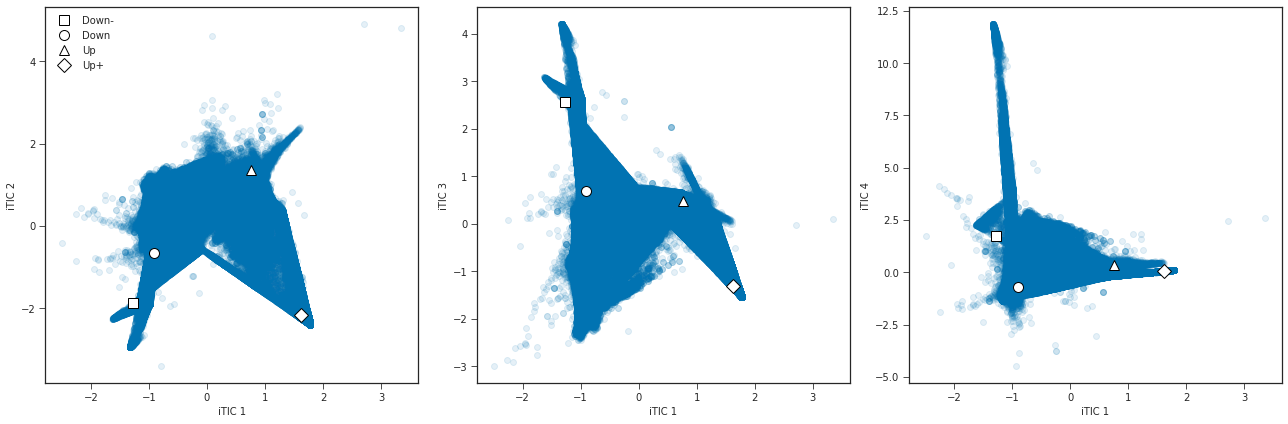

In [217]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(livac_arr[::10, 1], livac_arr[::10, i + 2], alpha=0.1)
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_livac[:, 1:3])
util.plot_models(axs[1], models_livac[:, 1:4:2])
util.plot_models(axs[2], models_livac[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/ivac-radial-dataproj.png", dpi=300)

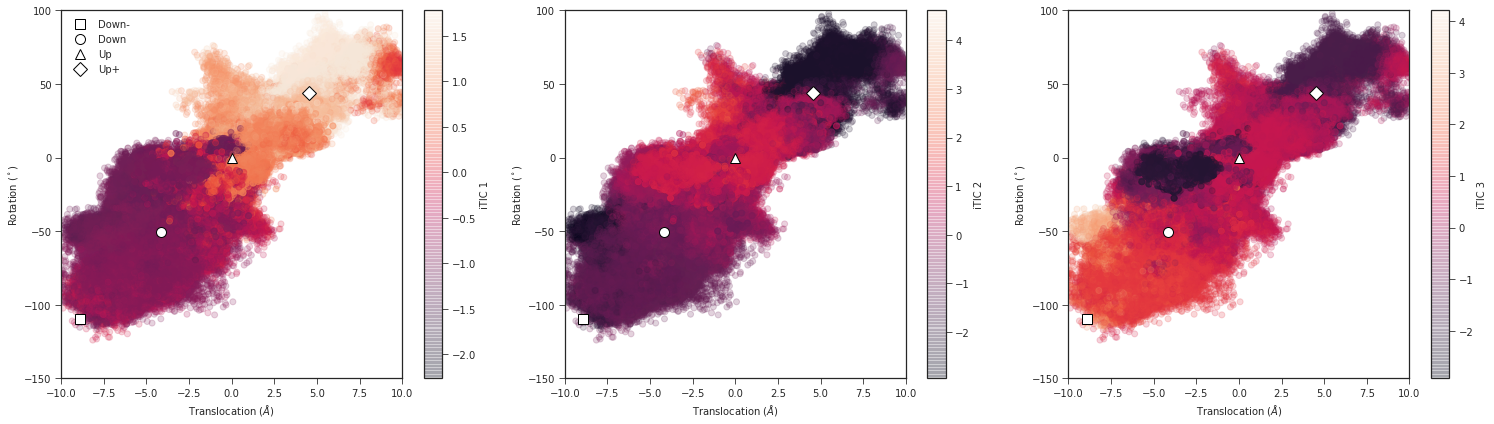

In [218]:
f, axs = plt.subplots(1, 3, figsize=(21, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::20, 0],
        cv_arr[::20, 1],
        c=livac_arr[::20, i + 1],
        cmap="rocket",
        alpha=0.2,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel(f"iTIC {i+1}")
    util.format_cvs(ax)
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/ivac-radial-ds-iTIC-proj.png", dpi=300)

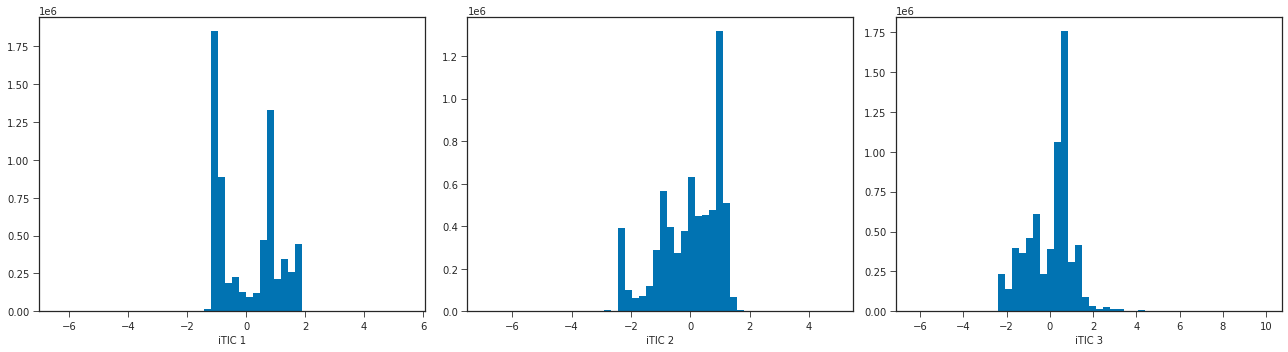

In [74]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(livac_arr[:, i + 1], bins=50)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()

In [94]:
print(np.where(livac_arr[:, 1] > 3))
print(np.where(livac_arr[:, 1] < -4))

(array([ 324119, 1823183, 1823184, 3260070]),)
(array([ 591485,  591519,  687978, 3134297, 4807568, 6310841, 6340841,
       6430841, 6450841, 6470841]),)


In [95]:
util.frame(3260070)

(1026, 70)

Not much difference between low TIC 1 and high TIC 1, maybe spurious - main difference is how "compacted" the helices are

In [97]:
idxs_0 = ((livac_arr[:, 1]) ** 2).argsort()
print(idxs_0[:10])

[ 951403 2703259  950110 3126110 4165431 3988221 5067123 4919891  950555
 4875103]


In [100]:
util.frame(950110)

(316, 2110)

# Indicator basis (kmeans, 50 clusters)

In [116]:
km = pyemma.coordinates.cluster_mini_batch_kmeans(data=data_sb_arr, k=50, n_jobs=16)

30-04-21 14:52:03 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[6] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


In [118]:
km.describe()

'[Kmeans, k=50, inp_dim=6]'

In [117]:
data_km50_arr = km.dtrajs

In [120]:
data_km50_arr[0].shape

(6580000,)

In [121]:
data_km50_arr = data_km50_arr[0]

In [122]:
data_km50_arr[:10]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [123]:
# indicator basis
data_ind_basis = np.zeros((len(data_sb_arr), 50))
for i in range(50):
    data_ind_basis[data_km50_arr == i, i] = 1

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  # This is added back by InteractiveShellApp.init_path()
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


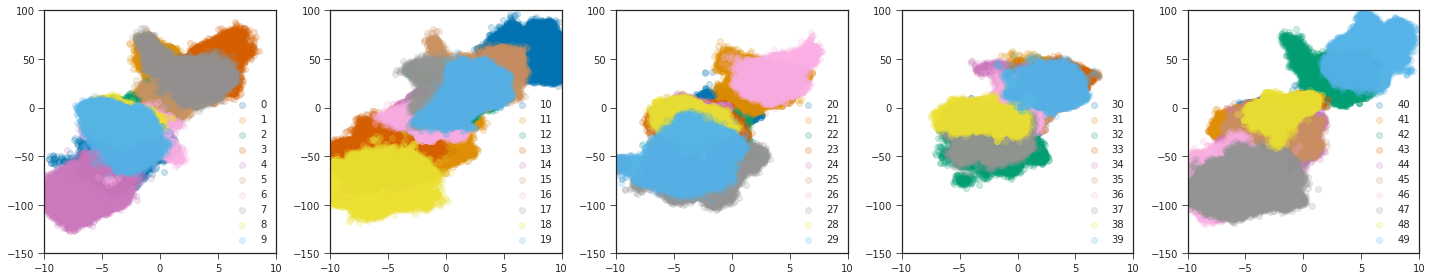

In [141]:
# plot cluster centers
f, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axs):
    for j in range(i * 10, (i + 1) * 10):
        cluster_ids = (data_km50_arr == j).nonzero()[0]
        ax.scatter(*cv_arr[cluster_ids, :].T, alpha=0.2, label=f"{j}")

    ax.set_xlim([-10, 10])
    ax.set_ylim([-150, 100])
    ax.legend()
f.tight_layout()

In [134]:
# IVAC
data_ind_trajs = np.split(data_ind_basis, traj_inds)
livac_km = ivac.LinearIVAC(
    minlag=1, maxlag=3000, nevecs=5, reweight=False, adjust=True, method="fft"
)
livac_km.fit(data_ind_trajs)

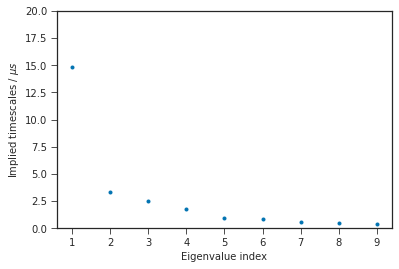

In [219]:
# f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac_km.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/ivac-ind50-its.png", dpi=300)

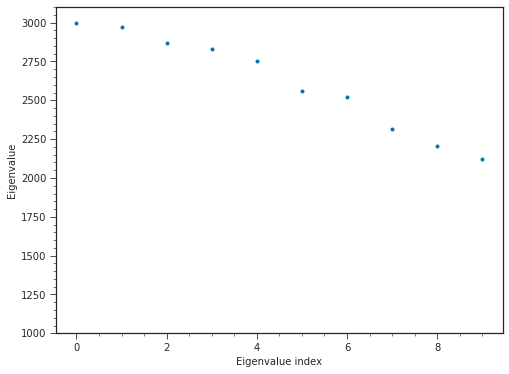

In [220]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac_km.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1000, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/ivac-ind50-evals.png", dpi=300)

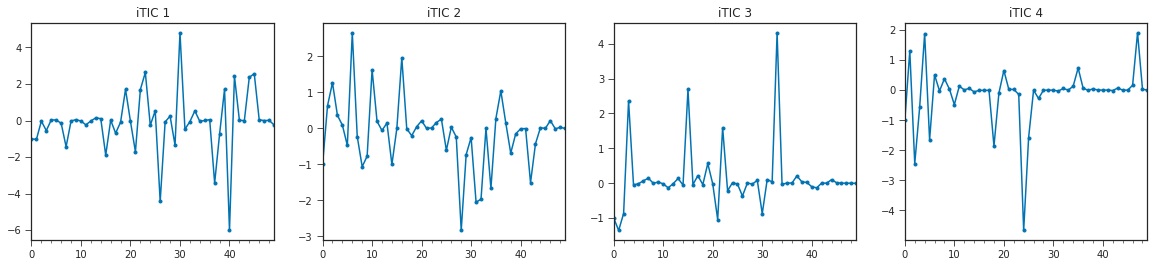

In [221]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(livac_km.evecs[i + 1], ".-")
    ax.set_xlim([0, 49])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")

plt.savefig("../fig/ivac-ind50-evecs.png", dpi=300)

In [144]:
livac_km_trajs = livac_km.transform(data_ind_trajs)
livac_km_arr = np.concatenate(livac_km_trajs)
models_km_arr = km.assign(models_sb)
models_ind_basis = np.zeros((4, 50))
for i in range(50):
    models_ind_basis[models_km_arr == i, i] = 1
models_km = livac_km.transform([models_ind_basis])[0]

In [145]:
livac_km_arr.shape

(6580000, 5)

In [146]:
models_km.shape

(4, 5)

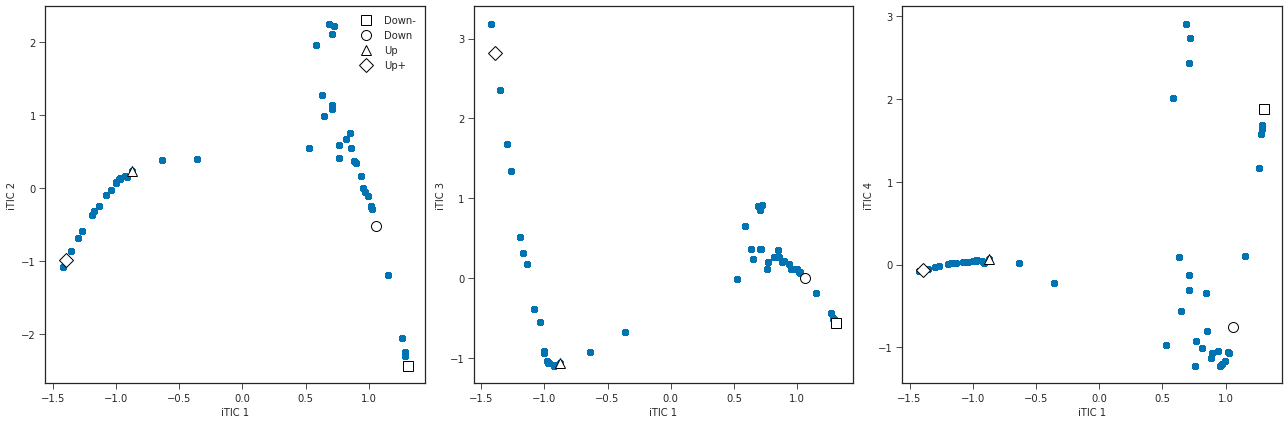

In [222]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(livac_km_arr[::10, 1], livac_km_arr[::10, i + 2], alpha=0.1)
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_km[:, 1:3])
util.plot_models(axs[1], models_km[:, 1:4:2])
util.plot_models(axs[2], models_km[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/ivac-ind50-dataproj.png", dpi=300)

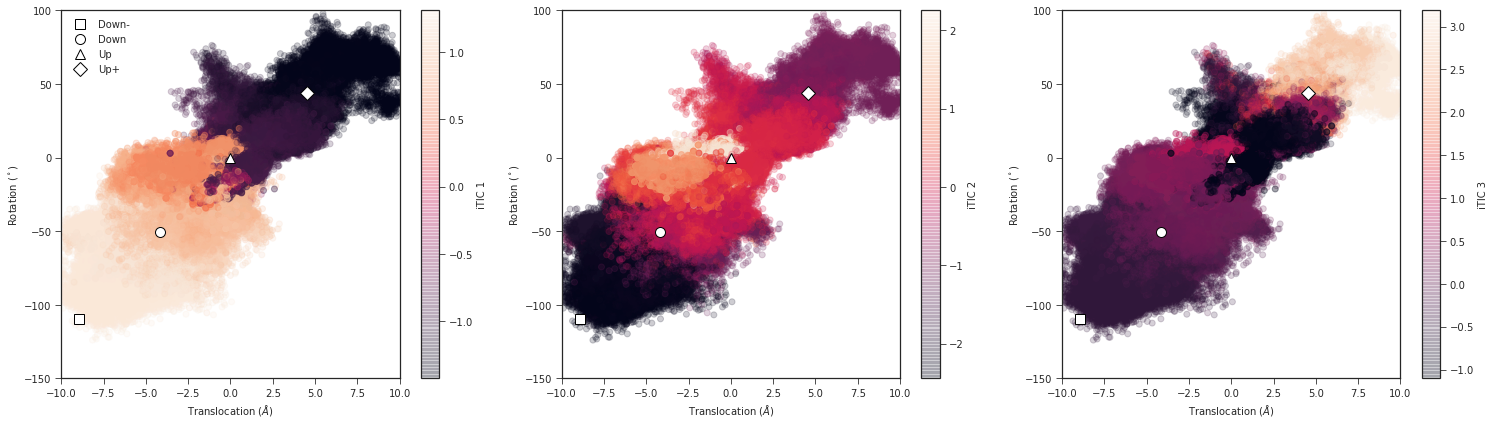

In [223]:
f, axs = plt.subplots(1, 3, figsize=(21, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::20, 0],
        cv_arr[::20, 1],
        c=livac_km_arr[::20, i + 1],
        cmap="rocket",
        alpha=0.2,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel(f"iTIC {i+1}")
    util.format_cvs(ax)
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/ivac-ind50-ds-iTIC-proj.png", dpi=300)

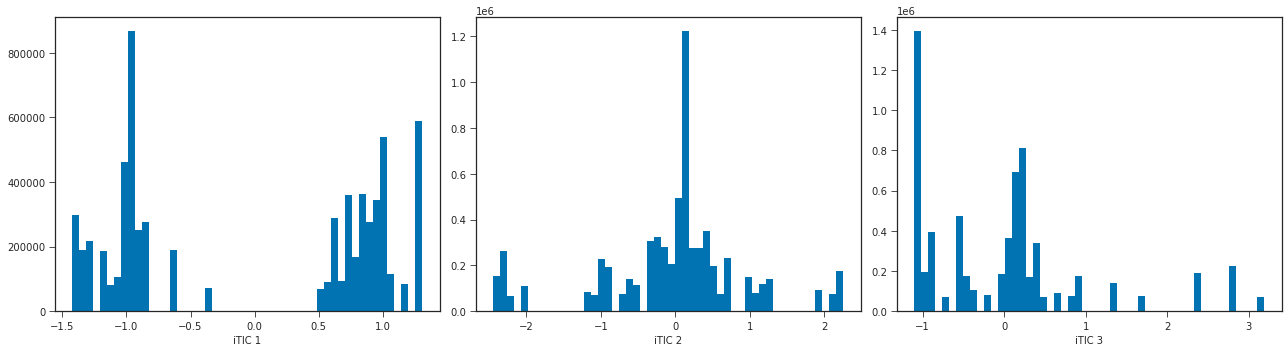

In [151]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(livac_km_arr[:, i + 1], bins=50)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()

# Indicator basis (kmeans, 200 clusters)

In [164]:
km200 = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=data_sb_arr, k=200, max_iter=100, n_jobs=16
)

30-04-21 18:45:44 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[10] INFO     Cluster centers converged after 37 steps.


In [165]:
data_km200_arr = km200.dtrajs

In [166]:
data_km200_arr = data_km200_arr[0]

In [184]:
# indicator basis
data_ind_basis_200 = np.zeros((len(data_sb_arr), 200))
for i in range(200):
    data_ind_basis_200[data_km200_arr == i, i] = 1

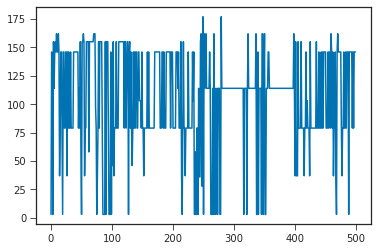

In [176]:
plt.plot(data_km200_arr[10000:20000:20])

In [185]:
# IVAC
data_ind200_trajs = np.split(data_ind_basis_200, traj_inds)
livac_km200 = ivac.LinearIVAC(
    minlag=1,
    maxlag=3000,
    nevecs=5,
    addones=False,
    reweight=False,
    adjust=True,
    method="fft",
)
livac_km200.fit(data_ind200_trajs)

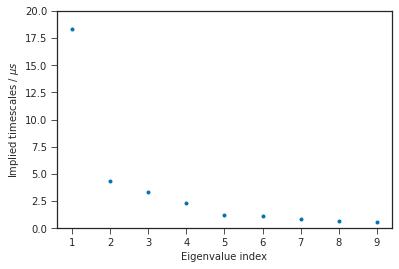

In [224]:
# f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac_km200.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/ivac-ind200-its.png", dpi=300)

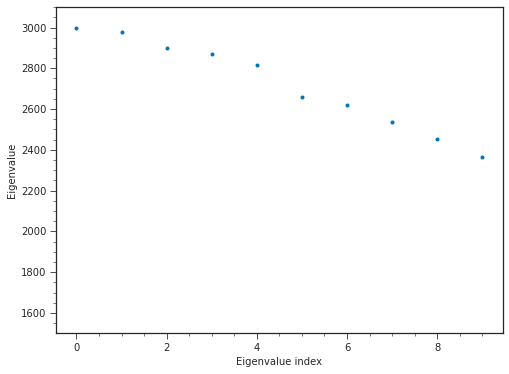

In [225]:
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(livac_km200.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1500, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/ivac-ind200-evals.png", dpi=300)

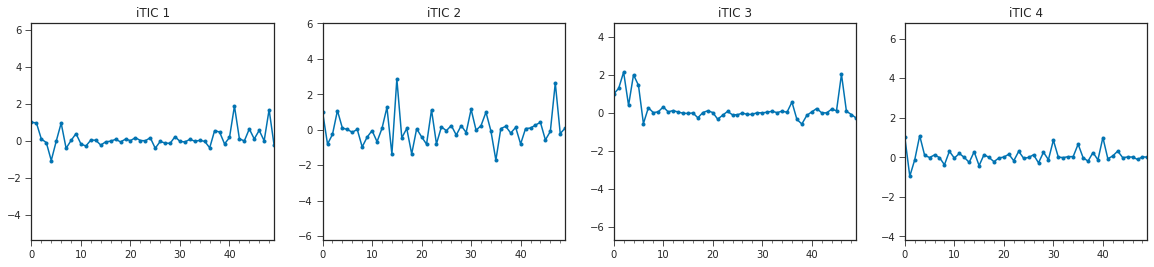

In [226]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(livac_km200.evecs[i + 1], ".-")
    ax.set_xlim([0, 49])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")
plt.savefig("../fig/ivac-ind200-evecs.png", dpi=300)

In [190]:
livac_km200_trajs = livac_km200.transform(data_ind200_trajs)
livac_km200_arr = np.concatenate(livac_km200_trajs)
models_km200_arr = km200.assign(models_sb)
models_ind200_basis = np.zeros((4, 200))
for i in range(200):
    models_ind200_basis[models_km200_arr == i, i] = 1
models_km200 = livac_km200.transform([models_ind200_basis])[0]

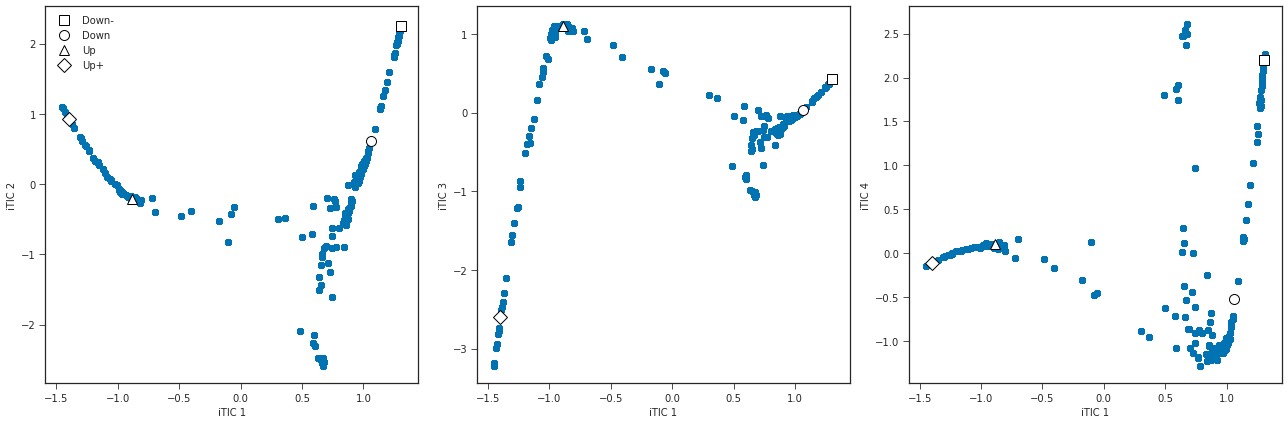

In [227]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(livac_km200_arr[::10, 1], livac_km200_arr[::10, i + 2], alpha=0.1)
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_km200[:, 1:3])
util.plot_models(axs[1], models_km200[:, 1:4:2])
util.plot_models(axs[2], models_km200[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/ivac-ind200-dataproj.png", dpi=300)

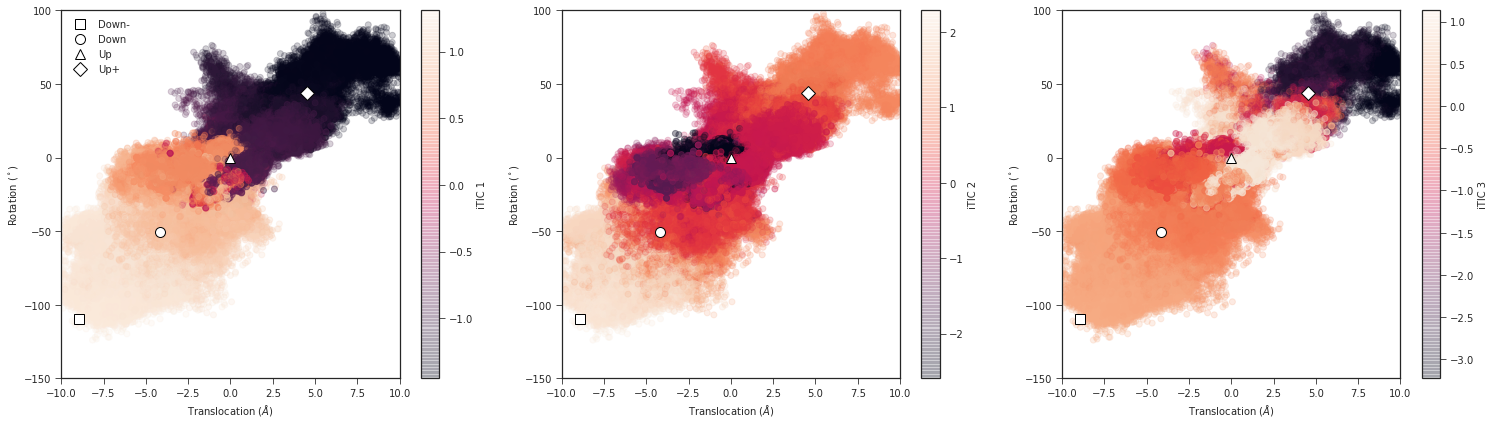

In [228]:
f, axs = plt.subplots(1, 3, figsize=(21, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::20, 0],
        cv_arr[::20, 1],
        c=livac_km200_arr[::20, i + 1],
        cmap="rocket",
        alpha=0.2,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel(f"iTIC {i+1}")
    util.format_cvs(ax)
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/ivac-ind200-ds-iTIC-proj.png", dpi=300)

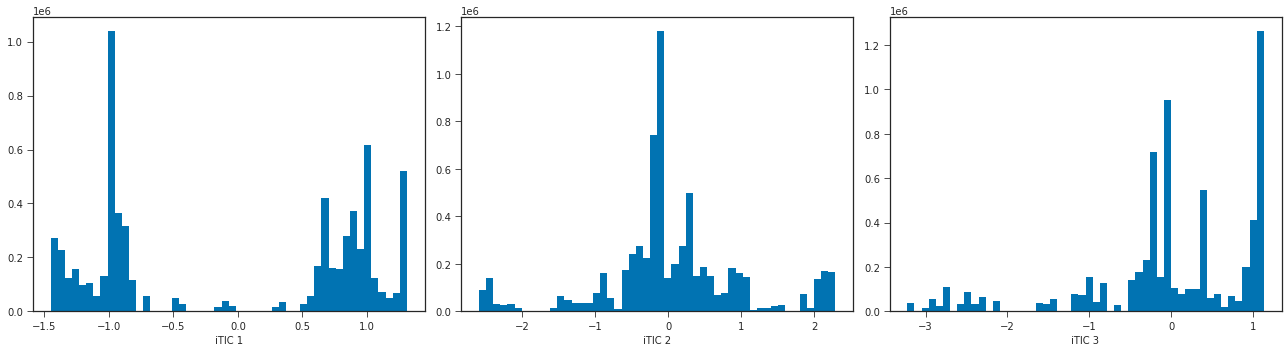

In [193]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(livac_km200_arr[:, i + 1], bins=50)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()

# Indicator basis (kmeans, 100 clusters)

In [177]:
km100 = pyemma.coordinates.cluster_mini_batch_kmeans(
    data=data_sb_arr, k=100, max_iter=100, n_jobs=16
)

30-04-21 19:02:05 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[12] INFO     Cluster centers converged after 12 steps.


In [26]:
data_km100_arr = km100.dtrajs

In [27]:
data_km100_arr = data_km100_arr[0]

In [28]:
# indicator basis
data_ind_basis_100 = np.zeros((len(data_sb_arr), 100))
for i in range(100):
    data_ind_basis_100[data_km100_arr == i, i] = 1

In [29]:
data_ind_basis_100.shape

(6580000, 100)

## Load 

In [21]:
km100 = pyemma.coordinates.cluster_mini_batch_kmeans()
km100 = km100.load("../data/sb_ind100_TICA/km100")

In [24]:
len(km100.dtrajs[0])

6580000

In [37]:
livac_km100_trajs = np.load("../data/sb_ind100_TICA/livac_trajs.npy", allow_pickle=True)
models_km100 = np.load("../data/sb_ind100_TICA/models.npy", allow_pickle=True)

In [38]:
livac_km100_arr = np.concatenate(livac_km100_trajs)

In [39]:
livac_km100_arr.shape

(6580000, 5)

In [30]:
# IVAC
data_ind100_trajs = np.split(data_ind_basis_100, traj_inds)
livac_km100 = ivac.LinearIVAC(
    minlag=1,
    maxlag=3000,
    nevecs=5,
    addones=False,
    reweight=False,
    adjust=True,
    method="fft",
)
livac_km100.fit(data_ind100_trajs)

In [31]:
sns.set_context("talk")

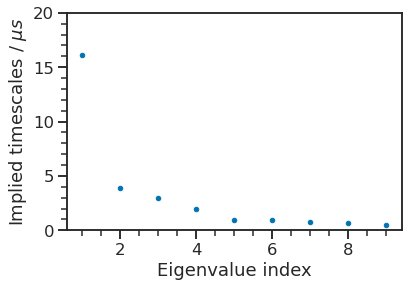

In [33]:
f, ax = plt.subplots()
plt.plot(livac_km100.its[:10] * 0.0001, ".")  # in units of us
plt.ylabel("Implied timescales / $\mu s$")
plt.xlabel("Eigenvalue index")
plt.ylim([0, 20])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/talks/ivac-ind100-its.png", dpi=200)

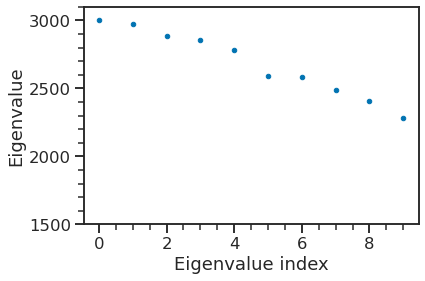

In [34]:
f, ax = plt.subplots()
plt.plot(livac_km100.evals[:10], ".")
plt.ylabel("Eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylim([1500, 3100])
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.savefig("../fig/talks/ivac-ind100-evals.png", dpi=200)

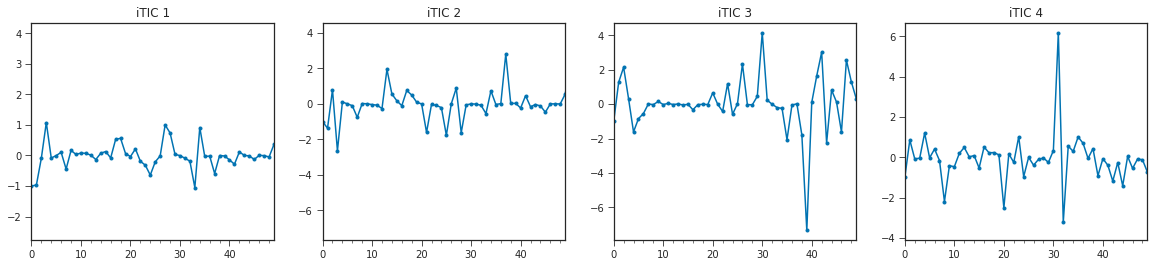

In [231]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.plot(livac_km100.evecs[i + 1], ".-")
    ax.set_xlim([0, 49])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_title(f"iTIC {i+1}")
plt.savefig("../fig/ivac-ind100-evecs.png", dpi=300)

In [208]:
livac_km100_trajs = livac_km100.transform(data_ind100_trajs)
livac_km100_arr = np.concatenate(livac_km100_trajs)
models_km100_arr = km100.assign(models_sb)
models_ind100_basis = np.zeros((4, 100))
for i in range(100):
    models_ind100_basis[models_km100_arr == i, i] = 1
models_km100 = livac_km100.transform([models_ind100_basis])[0]

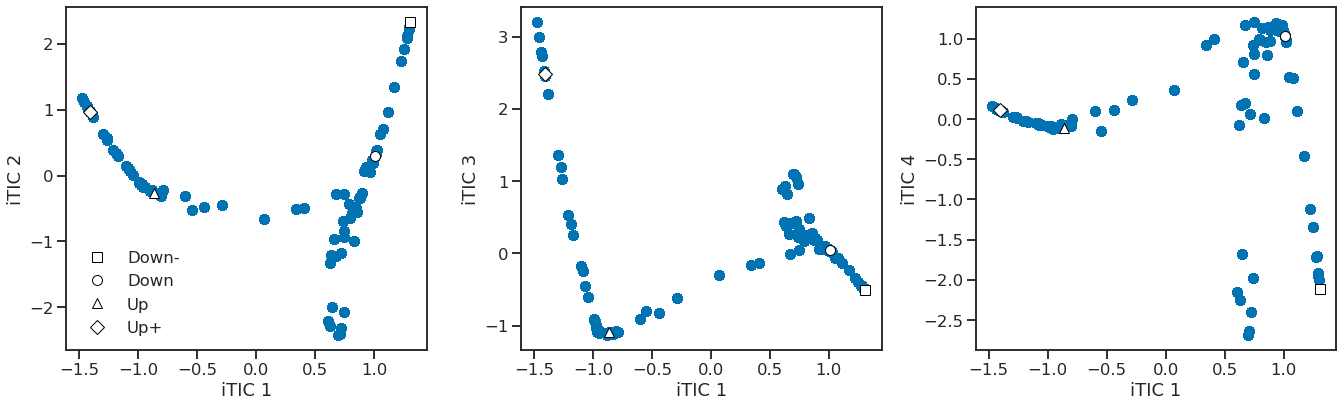

In [42]:
f, axs = plt.subplots(1, 3, figsize=(19, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(livac_km100_arr[::10, 1], livac_km100_arr[::10, i + 2], alpha=0.1)
    ax.set_xlabel(f"iTIC {1}")
    ax.set_ylabel(f"iTIC {i + 2}")

util.plot_models(axs[0], models_km100[:, 1:3])
util.plot_models(axs[1], models_km100[:, 1:4:2])
util.plot_models(axs[2], models_km100[:, 1:5:3])
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/talks/ivac-ind100-dataproj.png", dpi=300)

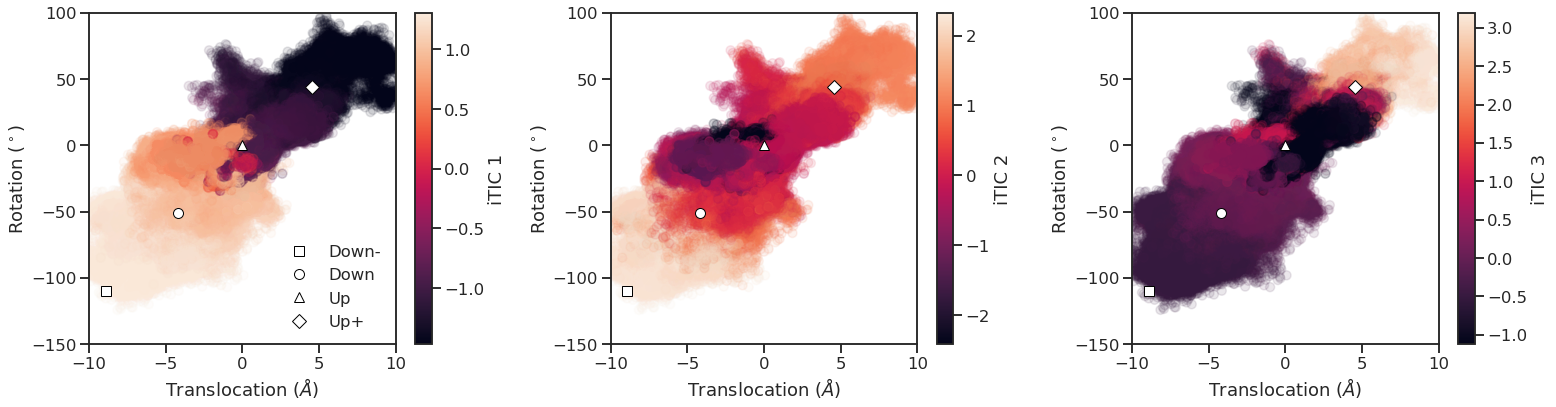

In [43]:
f, axs = plt.subplots(1, 3, figsize=(22, 6))
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::20, 0],
        cv_arr[::20, 1],
        c=livac_km100_arr[::20, i + 1],
        cmap="rocket",
        alpha=0.1,
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel(f"iTIC {i+1}")
    cbar.solids.set(alpha=1)
    util.format_cvs(ax)

axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()
plt.savefig("../fig/talks/ivac-ind100-ds-iTIC-proj.png", dpi=300)

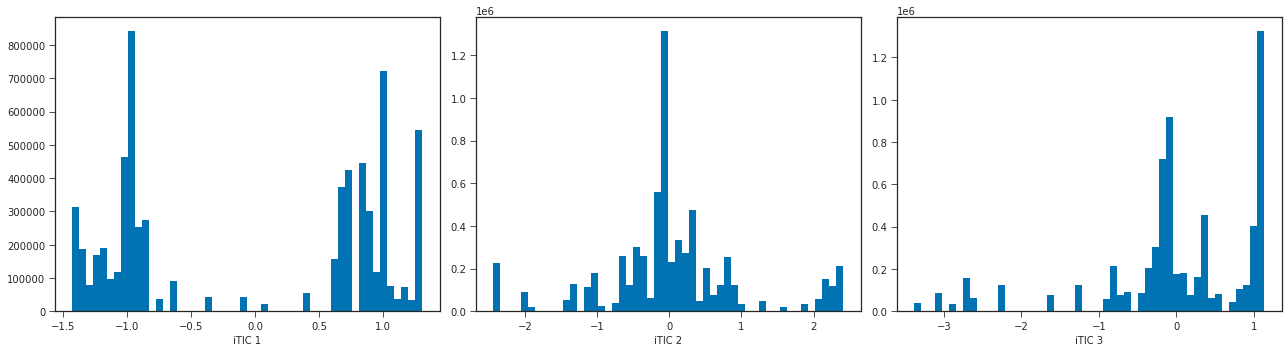

In [212]:
f, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axs):
    ax.hist(livac_km100_arr[:, i + 1], bins=50)
    ax.set_xlabel(f"iTIC {i+1}")
f.tight_layout()